# Analysis of model performances on pre/post ambiguity gridsearch

In [1]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import SkeletonDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
grid_dict = {}
grid_dir = '/neurospin/dico/lguillon/distmap/gridsearch_lr5e-4/'
for folder in os.listdir(grid_dir):
    if 'n_' in folder:
        if os.path.isfile(os.path.join(grid_dir, folder, 'results_test.json')):
            n = re.search('n_([\d]{1,3})', folder).group(1)
            kl = re.search('kl_([\d]{1,2})', folder).group(1)
            with open(os.path.join(grid_dir, folder, 'results_test.json'), 'r') as f:
                grid_dict[(int(n), int(kl))] = json.load(f)

In [3]:
n_list = [list(grid_dict.keys())[k][0] for k in range(len(grid_dict))]
kl_list = [list(grid_dict.keys())[k][1] for k in range(len(grid_dict))]
loss = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['final_loss_val'][0] for i in range(len(grid_dict))]
gb = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['gb_pre'] for i in range(len(grid_dict))]
logreg = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['logreg_pre'] for i in range(len(grid_dict))]
svm = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['svm_pre'] for i in range(len(grid_dict))]

In [4]:
grid_df = pd.DataFrame(list(zip(n_list, kl_list, loss, gb, logreg, svm)), columns=['n', 'kl', 'loss', 'gb','logreg', 'svm'])

In [5]:
grid_df['mean_classif'] = list((grid_df.gb + grid_df.logreg + grid_df.svm)/3)

In [6]:
grid_df.sort_values(by=['mean_classif', 'loss'], ascending=[False, True])

,n,kl,loss,gb,logreg,svm,mean_classif
17,100,4,17165.892904,0.948508,1.000000,1.000000,0.982836
26,50,8,20551.902483,0.948456,0.989553,1.000000,0.979336
12,150,4,16777.611485,0.937996,1.000000,1.000000,0.979332
9,150,10,21133.906901,0.929105,0.989861,0.979608,0.966191
13,50,2,16829.031331,0.898495,1.000000,1.000000,0.966165
22,100,2,14761.479713,0.928027,0.979452,0.979452,0.962310
8,100,8,20207.614037,0.896863,0.989899,1.000000,0.962254
21,20,8,21073.405285,0.918561,0.969603,0.969603,0.952589
24,20,4,20148.578590,0.949476,0.968882,0.938317,0.952225
27,100,10,21529.536063,0.876713,1.000000,0.969313,0.948675


In [7]:
grid_df[['n', 'kl', 'loss', 'logreg']].sort_values(by=['logreg', 'loss'], ascending=[False, True])

,n,kl,loss,logreg
19,75,2,15431.062837,1.000000
12,150,4,16777.611485,1.000000
13,50,2,16829.031331,1.000000
17,100,4,17165.892904,1.000000
27,100,10,21529.536063,1.000000
8,100,8,20207.614037,0.989899
16,150,8,20450.873047,0.989899
6,40,2,17456.866269,0.989880
25,40,8,20816.982306,0.989861
14,75,10,21088.715030,0.989861


In [13]:
grid_df[grid_df.kl==2]

,n,kl,loss,gb,logreg,svm,mean_classif
3,20,2,19712.531750,0.854423,0.949055,0.959502,0.920993
6,40,2,17456.866269,0.823677,0.989880,0.979742,0.931100
7,150,2,13796.480475,0.782940,0.989553,0.989553,0.920682
13,50,2,16829.031331,0.898495,1.000000,1.000000,0.966165
19,75,2,15431.062837,0.836902,1.000000,1.000000,0.945634
22,100,2,14761.479713,0.928027,0.979452,0.979452,0.962310
23,4,2,24328.658982,0.761350,0.744526,0.725965,0.743947


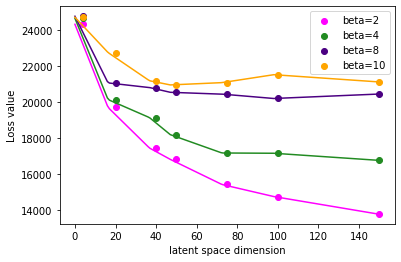

In [45]:
colors = {2: 'magenta', 4: 'forestgreen', 8: 'indigo', 10: 'orange'}
plt.subplot()

for b in [2, 4, 8, 10]:
    list_n = list(grid_df[grid_df.kl==b].n)
    list_loss = list(grid_df[grid_df.kl==b].loss)
    x_new = np.linspace(np.array(list_n).min(), np.array(list_n).max(),150)
    f = interp1d(list_n, list_loss, kind='linear')
    y_smooth=f(x_new)
    plt.scatter(list_n, list_loss, color=colors[b], label=f"beta={b}")
    plt.plot(y_smooth, color=colors[b])

plt.xlabel('latent space dimension')
plt.ylabel('Loss value')
plt.legend()
plt.show()

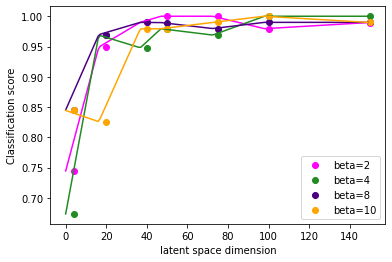

In [44]:
colors = {2: 'magenta', 4: 'forestgreen', 8: 'indigo', 10: 'orange'}
plt.subplot()

for b in [2, 4, 8, 10]:
    list_n = list(grid_df[grid_df.kl==b].n)
    list_loss = list(grid_df[grid_df.kl==b].logreg)
    x_new = np.linspace(np.array(list_n).min(), np.array(list_n).max(),150)
    f = interp1d(list_n, list_loss, kind='linear')
    y_smooth=f(x_new)
    plt.scatter(list_n, list_loss, color=colors[b], label=f"beta={b}")
    plt.plot(y_smooth, color=colors[b])

plt.xlabel('latent space dimension')
plt.ylabel('Classification score')
plt.legend()
plt.show()

#### Model choice
...

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"

In [28]:
model_dir = '/neurospin/dico/lguillon/distmap/gridsearch_lr5e-4/n_4_kl_10/checkpoint.pt'
#model_dir = '/neurospin/dico/lguillon/distmap/checkpoint.pt'
model = VAE((1, 80, 80, 96), 4, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

### Data

In [29]:
data_dir = "/neurospin/dico/lguillon/distmap/analyses_gridsearch/4_10/"
df_encoded_hcp = pd.read_pickle(os.path.join(data_dir, "encoded_hcp.pkl"))
#df_encoded_oh = pd.read_pickle(os.path.join(data_dir, "encoded_oh.pkl"))
#aims_data = pd.read_pickle(os.path.join(data_dir, "encoded_aims.pkl"))

In [5]:
df_encoded_hcp.head()

,latent,loss,recon,input,Group,sub
0,"[1.4987683, -2.3709788, -0.38663277, -1.805903...",2201,1927,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,hcp,932554
1,"[1.2524024, 1.6419047, -0.8353577, -0.12615435...",2060,1791,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,hcp,387959
2,"[-0.11067161, 0.17486379, -0.8502037, 0.352294...",2135,1847,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,hcp,887373
3,"[-0.42013705, 1.1203433, -0.15884572, 0.602573...",2524,2266,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,hcp,704238
4,"[0.39948422, 2.767998, 0.6011206, -0.3999996, ...",1902,1633,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,hcp,169040


In [286]:
df_encoded_hcp[-7:]

,latent,loss,recon,input,Group,sub
200,"[-0.5108173, -1.3633481, 0.0028913165, -0.6194...",2506,2236,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,138231
201,"[-0.09315355, -0.73126143, 1.5508142, -0.73950...",3032,2775,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,510225
202,"[-0.082732975, -0.30004776, 1.8481869, 0.80898...",2577,2302,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,159946
203,"[-0.10918096, -0.98894966, -3.3643854, 0.64920...",1941,1665,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,140319
204,"[-0.88676214, -0.48784754, -1.4390776, -1.4372...",2431,2159,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,212419
205,"[0.798065, -0.7499985, 0.6710335, -1.9978501, ...",2032,1746,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,199251
206,"[-0.088275254, 0.4569301, 0.8285965, -0.602497...",2760,2479,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,111009


### Analysis of latent space

#### Reduced space - TSNE / UMAP

In [30]:
X_hcp = np.array(list(df_encoded_hcp['latent']))
labels_hcp = np.array(df_encoded_hcp['Group'])

from sklearn.manifold import TSNE
X_embedded_hcp = TSNE(n_components=2, random_state=12, perplexity=40).fit_transform(X_hcp)

In [31]:
scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
subjects_name_hcp = ['' for k in range(200)] + list(df_encoded_hcp[-7:]['sub'])

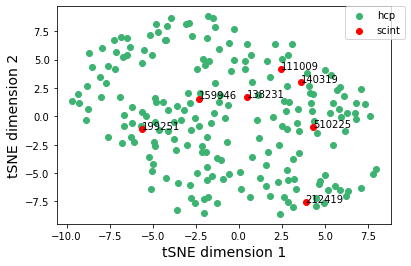

In [32]:
arr = X_embedded_hcp
color_dict = {'hcp':'mediumseagreen', 'scint': 'red'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_hcp):
    ix = np.where(labels_hcp == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

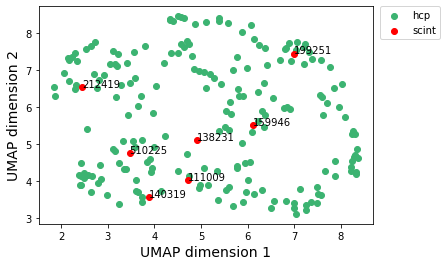

In [33]:
reducer = umap.UMAP(random_state=2)
embedding = reducer.fit_transform(X_hcp)

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_hcp):
    ix = np.where(labels_hcp == g)
    x = [embedding[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (embedding[i][0], embedding[i][1]))
    
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### With all subjects

In [73]:
data_dir = '/neurospin/dico/lguillon/distmap/data/'
filenames_all = np.load(os.path.join(data_dir,
                                "train_sub_id.npy"))
distmaps = np.load(os.path.join(data_dir,
                                "train_distmap.npy"),
                       mmap_mode='r')

subset_sc = SkeletonDataset(dataframe=distmaps, filenames=filenames_all, data_transforms=False)
sc_loader = torch.utils.data.DataLoader(
                          subset_sc,
                          batch_size=8,
                          num_workers=8,
                          shuffle=False)

In [74]:
criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders={'hcp_train': sc_loader},
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp_all = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
losses_hcp_all = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
recon_hcp_all = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
input_hcp_all = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}

df_encoded_hcp_all = pd.DataFrame()
df_encoded_hcp_all['latent'] = encoded_hcp_all['hcp_train']
df_encoded_hcp_all['loss'] = losses_hcp_all['hcp_train']
df_encoded_hcp_all['recon'] = recon_hcp_all['hcp_train']
df_encoded_hcp_all['input'] = input_hcp_all['hcp_train']
df_encoded_hcp_all['Group'] = ['hcp_train' for k in range(len(filenames_all))] 
df_encoded_hcp_all['sub'] = list(filenames_all)

hcp_train


In [75]:
X_train = np.array(list(df_encoded_hcp_all['latent']))
labels_train = np.array(df_encoded_hcp_all['Group'])

In [76]:
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(np.concatenate((X_train, X_hcp)))
embedding_test = reducer.transform(X_hcp)

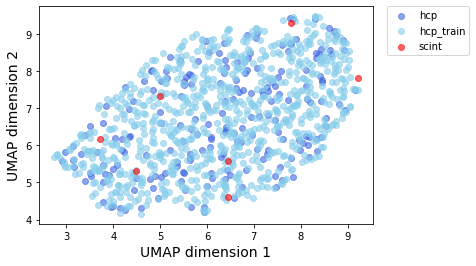

In [77]:
color_dict = {'hcp_train':'skyblue', 'hcp':'royalblue', 'scint': 'red'}

labels_all = np.concatenate((labels_train, labels_hcp))

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [embedding_all[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding_all[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=0.6)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [78]:
reducer = umap.UMAP()
embedding_train = reducer.fit_transform(X_train)
embedding_test = reducer.transform(X_hcp)

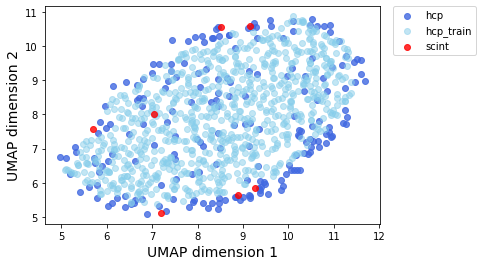

In [83]:
color_dict = {'hcp_train':'skyblue', 'hcp':'royalblue', 'scint': 'red'}

embedding_all = np.concatenate((embedding_train, embedding_test))
labels_all = np.concatenate((labels_train, labels_hcp))

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [embedding_all[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding_all[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp_train':
        ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=0.5)
    else:
        ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=0.8)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Outlier detection ML algorithm

In [34]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_hcp)

In [35]:
fp_list = {'oc':[], 'lof':[], 'if':[]}
tp_list = {'oc':[], 'lof':[], 'if':[]}
undetected_sub_oc = []
undetected_sub_if = []
fp_random = {}
tp_random = {}

for k in np.arange(0.05, 1, 0.01):
    tp_random[k] = []
    fp_random[k] = []
    clf = OneClassSVM(nu=k).fit(embedding)
    pred_ctrl = clf.predict(embedding)[:200]
    pred_scint = clf.predict(embedding)[200:]
    fp_list['oc'].append(len(pred_ctrl[pred_ctrl==-1])/200)
    tp_list['oc'].append(len(pred_scint[pred_scint==-1])/7)
    undetected_sub_oc.append(np.where(pred_scint[pred_scint==1]))
    nb_outliers = len(clf.predict(embedding)[clf.predict(embedding)==-1])
    for i in range(1000):
        rand_outliers = np.array(random.sample(range(207), nb_outliers))
        tp_random[k].append(len(rand_outliers[rand_outliers>=200])/7)
        fp_random[k].append(len(rand_outliers[rand_outliers<200])/200)

    
    clf = IsolationForest(random_state=10, contamination=k).fit(embedding)
    pred_ctrl = clf.predict(embedding)[:200]
    pred_scint = clf.predict(embedding)[200:]
    fp_list['if'].append(len(pred_ctrl[pred_ctrl==-1])/200)
    tp_list['if'].append(len(pred_scint[pred_scint==-1])/7)
    undetected_sub_if.append(np.where(pred_scint[pred_scint==1]))

In [36]:
mean_random_fp = [np.mean(fp_random[k]) for k in fp_random.keys()]
mean_random_tp = [np.mean(tp_random[k]) for k in tp_random.keys()]

quantile_5_random_fp = [np.quantile(fp_random[k], 0.05) for k in fp_random.keys()]
quantile_5_random_tp = [np.quantile(tp_random[k], 0.05) for k in tp_random.keys()]

quantile_95_random_fp = [np.quantile(fp_random[k], 0.95) for k in fp_random.keys()]
quantile_95_random_tp = [np.quantile(tp_random[k], 0.95) for k in tp_random.keys()]

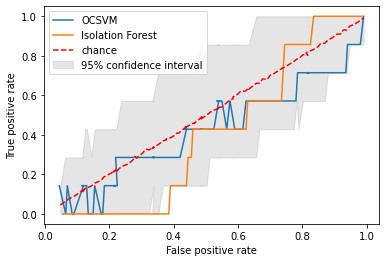

In [37]:
plt.subplot()
plt.plot(fp_list['oc'], tp_list['oc'], label='OCSVM')
plt.plot(fp_list['if'], tp_list['if'], label='Isolation Forest')

plt.plot(mean_random_fp, mean_random_tp, linestyle='--', label='chance', c='r')
#plt.plot(quantile_5_random_fp, quantile_5_random_tp, label='5th quantile')
#plt.plot(quantile_95_random_fp, quantile_95_random_tp, label='95th percentile')

plt.fill_between(mean_random_fp, quantile_5_random_tp, quantile_95_random_tp, color='grey', alpha=.2,
            label=f"95% confidence interval")


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

In [38]:
average_fp_list = {'oc': {k: [] for k in np.arange(0.05, 1, 0.1)}, 'if': {k: [] for k in np.arange(0.05, 1, 0.1)}}
average_tp_list = {'oc': {k: [] for k in np.arange(0.05, 1, 0.1)}, 'if': {k: [] for k in np.arange(0.05, 1, 0.1)}}

for k in range(10):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(X_hcp)
    fp_list = {'oc':[], 'lof':[], 'if':[]}
    tp_list = {'oc':[], 'lof':[], 'if':[]}
    undetected_sub_oc = []
    undetected_sub_if = []
    fp_random = {}
    tp_random = {}

    for k in np.arange(0.05, 1, 0.1):
        tp_random[k] = []
        fp_random[k] = []
        clf = OneClassSVM(nu=k).fit(embedding)
        pred_ctrl = clf.predict(embedding)[:200]
        pred_scint = clf.predict(embedding)[200:]
        #fp_list['oc'].append(len(pred_ctrl[pred_ctrl==-1])/200)
        #tp_list['oc'].append(len(pred_scint[pred_scint==-1])/7)
        
        average_fp_list['oc'][k].append(len(pred_ctrl[pred_ctrl==-1])/200)
        average_tp_list['oc'][k].append(len(pred_scint[pred_scint==-1])/7)
        
        undetected_sub_oc.append(np.where(pred_scint==1))
        nb_outliers = len(clf.predict(embedding)[clf.predict(embedding)==-1])

        clf = IsolationForest(random_state=10, contamination=k).fit(embedding)
        pred_ctrl = clf.predict(embedding)[:200]
        pred_scint = clf.predict(embedding)[200:]
        
        average_fp_list['if'][k].append(len(pred_ctrl[pred_ctrl==-1])/200)
        average_tp_list['if'][k].append(len(pred_scint[pred_scint==-1])/7)
        
        undetected_sub_if.append(np.where(pred_scint==1))
        
        for i in range(1000):
            rand_outliers = np.array(random.sample(range(207), nb_outliers))
            tp_random[k].append(len(rand_outliers[rand_outliers>=200])/7)
            fp_random[k].append(len(rand_outliers[rand_outliers<200])/200)
        
        
mean_random_fp = [np.mean(fp_random[k]) for k in fp_random.keys()]
mean_random_tp = [np.mean(tp_random[k]) for k in tp_random.keys()]

quantile_5_random_fp = [np.quantile(fp_random[k], 0.05) for k in fp_random.keys()]
quantile_5_random_tp = [np.quantile(tp_random[k], 0.05) for k in tp_random.keys()]

quantile_95_random_fp = [np.quantile(fp_random[k], 0.95) for k in fp_random.keys()]
quantile_95_random_tp = [np.quantile(tp_random[k], 0.95) for k in tp_random.keys()]

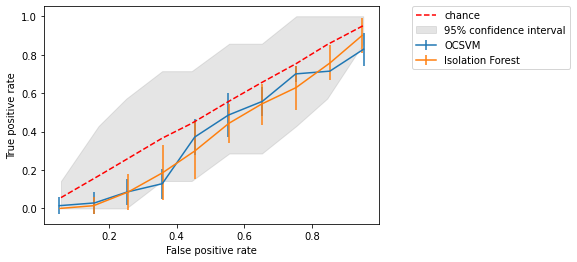

In [39]:
fp_oc = [np.mean(average_fp_list['oc'][k]) for k in average_fp_list['oc'].keys()]
tp_oc = [np.mean(average_tp_list['oc'][k]) for k in average_tp_list['oc'].keys()]
error_oc = [np.std(average_tp_list['oc'][k]) for k in average_tp_list['oc'].keys()]
fp_if = [np.mean(average_fp_list['if'][k]) for k in average_fp_list['if'].keys()]
tp_if = [np.mean(average_tp_list['if'][k]) for k in average_tp_list['if'].keys()]
error_if = [np.std(average_tp_list['if'][k]) for k in average_tp_list['if'].keys()]

plt.subplot()
plt.errorbar(fp_oc, tp_oc, yerr=error_oc,label='OCSVM')
plt.errorbar(fp_if, tp_if, yerr=error_if, label='Isolation Forest')

plt.plot(mean_random_fp, mean_random_tp, linestyle='--', label='chance', c='r')
plt.fill_between(mean_random_fp, quantile_5_random_tp, quantile_95_random_tp, color='grey', alpha=.2,
            label=f"95% confidence interval")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(bbox_to_anchor=(1.1,1), borderaxespad=0)
#plt.legend()
plt.show()

### Which interrupted CS are missing ?

In [124]:
undetected_sub_oc

[(array([0, 1, 2, 3, 6]),),
 (array([0, 1, 2, 6]),),
 (array([0, 1, 2, 6]),),
 (array([0, 2]),),
 (array([0, 2]),),
 (array([0, 2]),),
 (array([0, 2]),),
 (array([2]),),
 (array([2]),),
 (array([2]),)]

In [125]:
df_encoded_hcp.loc[[200, 202]]

,latent,loss,recon,input,Group,sub
200,"[-0.5108173, -1.3633481, 0.0028913165, -0.6194...",2506,2236,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,138231
202,"[-0.082732975, -0.30004776, 1.8481869, 0.80898...",2577,2302,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,159946


### Which continuous CS are considered as outliers ?

In [131]:
for k in range(10):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(X_hcp)
    detected_sub_oc = []
    detected_sub_if = []

    for k in np.arange(0.05, 1, 0.1):
        tp_random[k] = []
        fp_random[k] = []
        clf = OneClassSVM(nu=k).fit(embedding)
        pred_ctrl = clf.predict(embedding)[:200]
        pred_scint = clf.predict(embedding)[200:]
        detected_sub_oc.append(np.where(pred_ctrl==-1))

        clf = IsolationForest(random_state=10, contamination=k).fit(embedding)
        pred_ctrl = clf.predict(embedding)[:200]
        pred_scint = clf.predict(embedding)[200:]      
        detected_sub_if.append(np.where(pred_ctrl==-1))

In [138]:
#detected_sub_oc

In [137]:
#detected_sub_if

8, 27, 160, 162, 92, 155, 41, 77, 122, 196

0, 2, 34, 43, 47,51, 52,91, 97, 100, 120,130, 135, 146,160, 162, 199

92, 155, 92

In [135]:
non_int_out = list(df_encoded_hcp.loc[[8, 27, 160, 162, 92, 155, 41, 77, 122, 196]]['sub'])

In [136]:
non_int_out

[679770,
 942658,
 268850,
 146331,
 185038,
 611938,
 116221,
 965367,
 176239,
 657659]

In [168]:
df_encoded_hcp['sub'][0]

932554

NameError: name 'non_int_out' is not defined

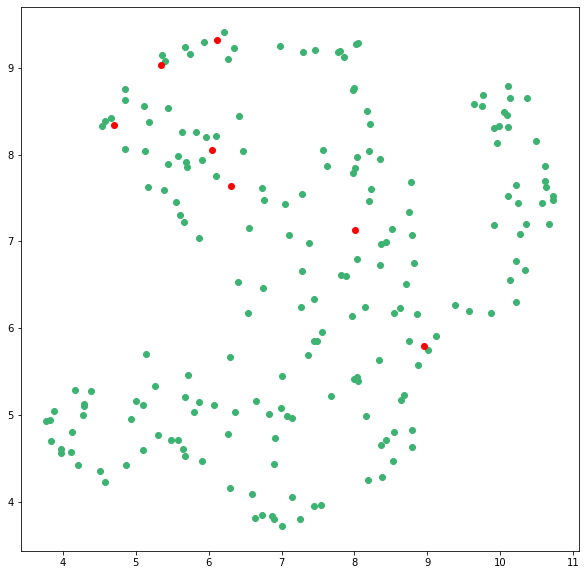

In [19]:
#reducer = umap.UMAP(random_state=2)
#embedding = reducer.fit_transform(X_hcp)

color_dict = {'hcp':'mediumseagreen', 'scint': 'red'}

fig = plt.figure(figsize=(10,10))
ax = fig.subplots()

for g in np.unique(labels_hcp):
    ix = np.where(labels_hcp == g)
    x = [embedding[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    

# now plot both limits against eachother
#ax.plot(ax.get_xlim(), ax.get_ylim(), 'k-', alpha=0.75)
for i, txt in enumerate(list(df_encoded_hcp['sub'])):
    if txt in non_int_out or txt in scint_list or txt in [872158]:
        ax.annotate(txt, (embedding[i][0], embedding[i][1]))
    
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

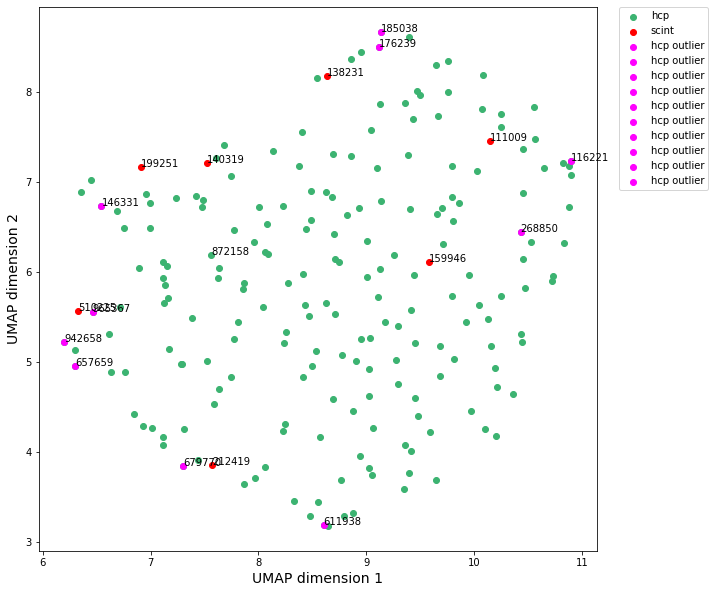

In [197]:
color_dict = {'hcp':'mediumseagreen', 'scint': 'red'}

fig = plt.figure(figsize=(10,10))
ax = fig.subplots()

ax.scatter([embedding[k][:200][0] for k in range(200)], [embedding[k][:200][1] for k in range(200)], c = color_dict['hcp'], label = 'hcp')
ax.scatter([embedding[k][0] for k in range(200, 207)], [embedding[k][1] for k in range(200, 207)], c = color_dict['scint'], label = 'scint')
    
for g in np.unique(non_int_out):
    ix = np.where(np.array(df_encoded_hcp['sub']) == g)
    x = [embedding[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = 'magenta', label = 'hcp outlier')
    

# now plot both limits against eachother
#ax.plot(ax.get_xlim(), ax.get_ylim(), 'k-', alpha=0.75)
for i, txt in enumerate(list(df_encoded_hcp['sub'])):
    if txt in non_int_out or txt in scint_list or txt in [872158]:
        ax.annotate(txt, (embedding[i][0], embedding[i][1]))
    
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [158]:
df_encoded_hcp[200:]

,latent,loss,recon,input,Group,sub
200,"[-0.5108173, -1.3633481, 0.0028913165, -0.6194...",2506,2236,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,138231
201,"[-0.09315355, -0.73126143, 1.5508142, -0.73950...",3032,2775,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,510225
202,"[-0.082732975, -0.30004776, 1.8481869, 0.80898...",2577,2302,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,159946
203,"[-0.10918096, -0.98894966, -3.3643854, 0.64920...",1941,1665,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,140319
204,"[-0.88676214, -0.48784754, -1.4390776, -1.4372...",2431,2159,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,212419
205,"[0.798065, -0.7499985, 0.6710335, -1.9978501, ...",2032,1746,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,199251
206,"[-0.088275254, 0.4569301, 0.8285965, -0.602497...",2760,2479,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,scint,111009


In [129]:
average_fp_list = {'oc': {k: [] for k in np.arange(0.05, 1, 0.1)}, 'if': {k: [] for k in np.arange(0.05, 1, 0.1)}}
average_tp_list = {'oc': {k: [] for k in np.arange(0.05, 1, 0.1)}, 'if': {k: [] for k in np.arange(0.05, 1, 0.1)}}

for k in range(10):
    fp_list = {'oc':[], 'lof':[], 'if':[]}
    tp_list = {'oc':[], 'lof':[], 'if':[]}
    undetected_sub_oc = []
    undetected_sub_if = []
    fp_random = {}
    tp_random = {}

    for k in np.arange(0.05, 1, 0.1):
        tp_random[k] = []
        fp_random[k] = []
        clf = OneClassSVM(nu=k).fit(X_hcp)
        pred_ctrl = clf.predict(X_hcp)[:200]
        pred_scint = clf.predict(X_hcp)[200:]
        #fp_list['oc'].append(len(pred_ctrl[pred_ctrl==-1])/200)
        #tp_list['oc'].append(len(pred_scint[pred_scint==-1])/7)
        
        average_fp_list['oc'][k].append(len(pred_ctrl[pred_ctrl==-1])/200)
        average_tp_list['oc'][k].append(len(pred_scint[pred_scint==-1])/7)
        
        undetected_sub_oc.append(np.where(pred_scint==1))
        nb_outliers = len(clf.predict(X_hcp)[clf.predict(X_hcp)==-1])

        clf = IsolationForest(random_state=10, contamination=k).fit(X_hcp)
        pred_ctrl = clf.predict(X_hcp)[:200]
        pred_scint = clf.predict(X_hcp)[200:]
        
        average_fp_list['if'][k].append(len(pred_ctrl[pred_ctrl==-1])/200)
        average_tp_list['if'][k].append(len(pred_scint[pred_scint==-1])/7)
        
        undetected_sub_if.append(np.where(pred_scint==1))
        
        for i in range(1000):
            rand_outliers = np.array(random.sample(range(207), nb_outliers))
            tp_random[k].append(len(rand_outliers[rand_outliers>=200])/7)
            fp_random[k].append(len(rand_outliers[rand_outliers<200])/200)
        
        
mean_random_fp = [np.mean(fp_random[k]) for k in fp_random.keys()]
mean_random_tp = [np.mean(tp_random[k]) for k in tp_random.keys()]

quantile_5_random_fp = [np.quantile(fp_random[k], 0.05) for k in fp_random.keys()]
quantile_5_random_tp = [np.quantile(tp_random[k], 0.05) for k in tp_random.keys()]

quantile_95_random_fp = [np.quantile(fp_random[k], 0.95) for k in fp_random.keys()]
quantile_95_random_tp = [np.quantile(tp_random[k], 0.95) for k in tp_random.keys()]

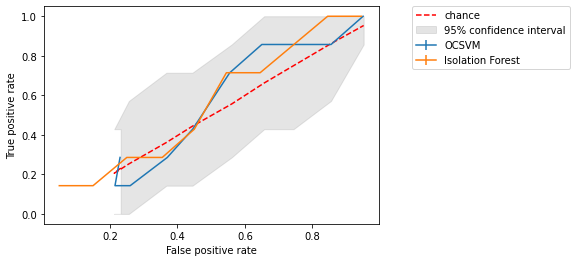

In [130]:
fp_oc = [np.mean(average_fp_list['oc'][k]) for k in average_fp_list['oc'].keys()]
tp_oc = [np.mean(average_tp_list['oc'][k]) for k in average_tp_list['oc'].keys()]
error_oc = [np.std(average_tp_list['oc'][k]) for k in average_tp_list['oc'].keys()]
fp_if = [np.mean(average_fp_list['if'][k]) for k in average_fp_list['if'].keys()]
tp_if = [np.mean(average_tp_list['if'][k]) for k in average_tp_list['if'].keys()]
error_if = [np.std(average_tp_list['if'][k]) for k in average_tp_list['if'].keys()]

plt.subplot()
plt.errorbar(fp_oc, tp_oc, yerr=error_oc,label='OCSVM')
plt.errorbar(fp_if, tp_if, yerr=error_if, label='Isolation Forest')

plt.plot(mean_random_fp, mean_random_tp, linestyle='--', label='chance', c='r')
plt.fill_between(mean_random_fp, quantile_5_random_tp, quantile_95_random_tp, color='grey', alpha=.2,
            label=f"95% confidence interval")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(bbox_to_anchor=(1.1,1), borderaxespad=0)
#plt.legend()
plt.show()

### Clusters ? 
how is the latent space organized ? 

For n_clusters = 2 The average silhouette_score with kmeans is : 0.3637127
For n_clusters = 3 The average silhouette_score with kmeans is : 0.3996799
For n_clusters = 4 The average silhouette_score with kmeans is : 0.37534034
For n_clusters = 5 The average silhouette_score with kmeans is : 0.36279878
For n_clusters = 6 The average silhouette_score with kmeans is : 0.35999566
For n_clusters = 7 The average silhouette_score with kmeans is : 0.37104797
For n_clusters = 8 The average silhouette_score with kmeans is : 0.37462077
For n_clusters = 9 The average silhouette_score with kmeans is : 0.37034982
For n_clusters = 10 The average silhouette_score with kmeans is : 0.36307368
For n_clusters = 11 The average silhouette_score with kmeans is : 0.37783918
For n_clusters = 12 The average silhouette_score with kmeans is : 0.37408957
For n_clusters = 13 The average silhouette_score with kmeans is : 0.3717357
For n_clusters = 14 The average silhouette_score with kmeans is : 0.3661108
For n_clust

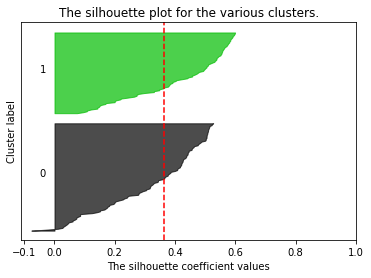

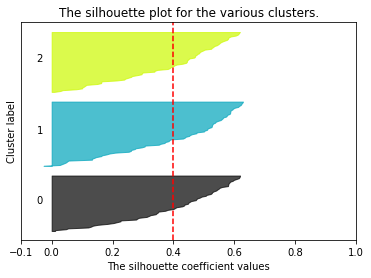

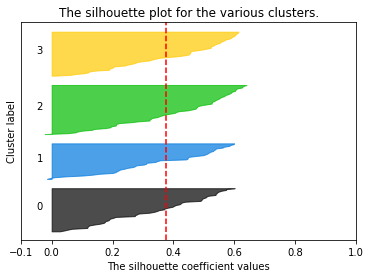

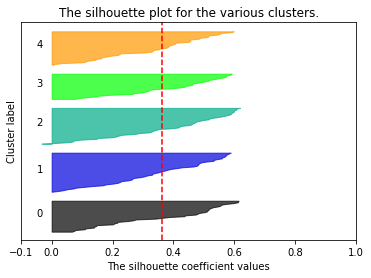

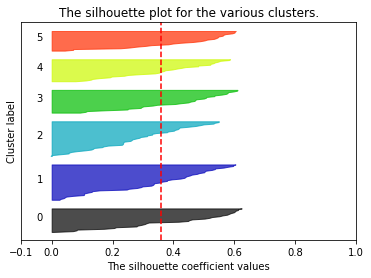

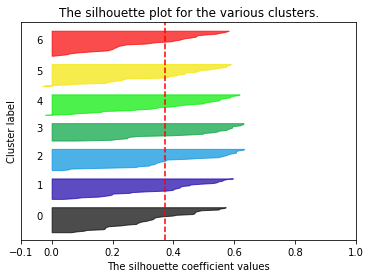

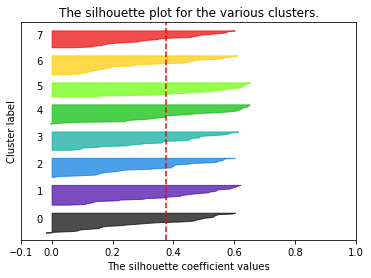

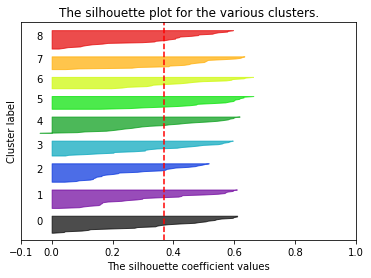

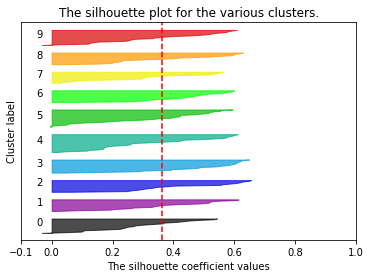

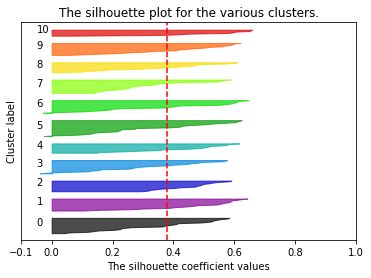

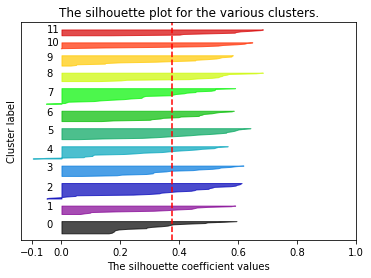

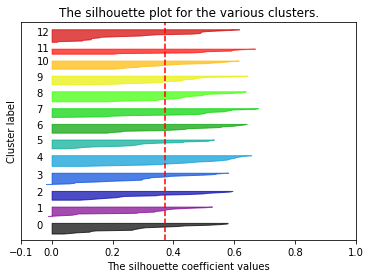

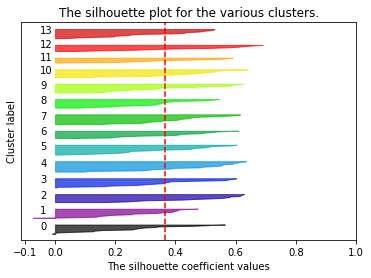

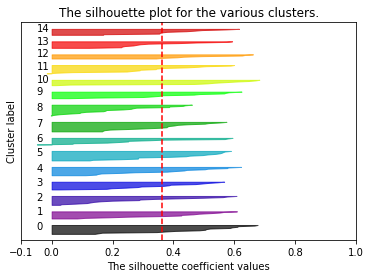

In [199]:
n_clusters_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n in n_clusters_list:
    cluster_labels= KMeans(n_clusters=n, random_state=0).fit_predict(embedding)

    fig, ax1 = plt.subplots()
    ax1.set_ylim([0, len(embedding) + (n + 1) * 10])
    silhouette_avg = silhouette_score(embedding, cluster_labels)
    print("For n_clusters =", n, "The average silhouette_score with kmeans is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(embedding, cluster_labels)

    y_lower = 10
    for i in range(n):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [200]:
af = AffinityPropagation(random_state=15, max_iter=1000).fit(embedding)
cluster_labels_ini = af.labels_
initial_centers = af.cluster_centers_indices_
n_clusters_ = len(initial_centers)
print(n_clusters_)
x_cluster_label = af.predict(embedding)
clusters_centroids = af.cluster_centers_
while n_clusters_ > 7:
    af = AffinityPropagation(random_state=0).fit(embedding[af.cluster_centers_indices_])
    center_cluster_labels = af.labels_
    x_cluster_label = af.predict(embedding)
    n_clusters_ = len(af.cluster_centers_indices_)
    print(n_clusters_)
    clusters_centroids = af.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

12
3
cluster's centroids coordinates: 
 [[9.6544    6.640173 ]
 [8.693859  4.5940285]
 [6.618083  5.31561  ]]


In [201]:
dstrb_clu = pd.DataFrame(embedding, index=list(df_encoded_hcp['sub'][:200]) + scint_list, columns=[1, 2])
dstrb_clu['cluster_lab'] = x_cluster_label

cluster1 = dstrb_clu[dstrb_clu.cluster_lab==0]
cluster2 = dstrb_clu[dstrb_clu.cluster_lab==1]
cluster3 = dstrb_clu[dstrb_clu.cluster_lab==2]
cluster4 = dstrb_clu[dstrb_clu.cluster_lab==3]

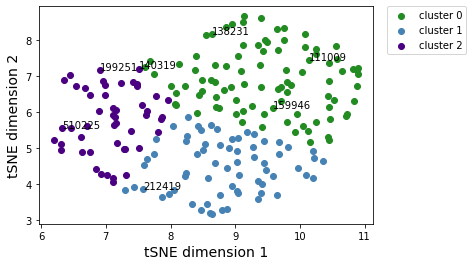

In [203]:
arr = np.array([np.array([dstrb_clu[k][i] for k in dstrb_clu.columns[:2]]) for i in range(len(dstrb_clu))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_clu.cluster_lab]):
    ix = np.where(dstrb_clu.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (embedding[i][0], embedding[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

### Distances to centroid

In [204]:
def centeroidnp(arr):
    length, dim = arr.shape
    return np.array([np.sum(arr[:, i])/length for i in range(dim)])

In [205]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(1, len(df.columns)+1)]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [206]:
dstrb_sub_hcp = pd.DataFrame(X_hcp, index=list(df_encoded_hcp['sub']), columns=[k for k in range(1, len(df_encoded_hcp.latent[0])+1)])

In [207]:
dstrb_sub_hcp.head()

,1,2,3,4,5,6,7,8,9,10,...,66,67,68,69,70,71,72,73,74,75
932554,1.498768,-2.370979,-0.386633,-1.805903,-1.640908,0.889017,-0.788837,1.798124,-0.226252,2.262826,...,-0.102943,-2.583251,0.855373,-2.297728,0.038101,-0.507936,0.148095,-0.890834,0.816926,0.593571
387959,1.252402,1.641905,-0.835358,-0.126154,-0.787843,0.480225,-0.496849,-0.422218,1.169830,-0.576299,...,-0.195885,2.280522,1.421875,0.870732,0.323759,-0.757779,0.312783,0.208075,2.278088,1.087756
887373,-0.110672,0.174864,-0.850204,0.352294,2.037961,3.249742,0.055441,-1.478776,-1.323680,-2.021513,...,-0.471757,-0.544958,1.041807,-0.735108,-0.411240,0.858377,-2.503704,0.575416,-0.044089,1.783877
704238,-0.420137,1.120343,-0.158846,0.602574,-0.284027,-2.788037,0.835695,0.760048,1.396570,0.260587,...,-1.462170,-0.448359,1.350685,-0.714808,0.236187,2.234452,1.398382,-0.855307,-0.031911,-0.364948
169040,0.399484,2.767998,0.601121,-0.400000,0.480090,0.142670,-1.033846,1.149555,-0.549302,-0.302024,...,-1.297961,-0.018789,-0.645050,0.094646,-0.498234,-0.189802,-2.034818,0.823724,0.716479,-0.066602


In [208]:
centroid = closest_distance(centeroidnp(X_hcp), dstrb_sub_hcp)
print(centroid)

571144


In [209]:
dist_centroid_ctrl = [distance.cityblock(list(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].latent)[k], centroid) for k in range(len(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].latent))]
dist_centroid_scint = [distance.cityblock(list(df_encoded_hcp[df_encoded_hcp.Group=='scint'].latent)[k], centroid) for k in range(len(df_encoded_hcp[df_encoded_hcp.Group=='scint'].latent))]

In [210]:
F,p = mannwhitneyu(dist_centroid_ctrl, dist_centroid_scint)
print(p)

0.3254298432824096


In [211]:
""" In reduced space """
dstrb_sub_red = pd.DataFrame(X_embedded_hcp, index=list(df_encoded_hcp['sub']), columns=[1, 2])
centroid_red = closest_distance(centeroidnp(X_embedded_hcp), dstrb_sub_red)
print(centroid_red)
dist_centroid_ctrl_red = [distance.cityblock(X_embedded_hcp[k], centroid_red) for k in range(len(df_encoded_hcp[df_encoded_hcp.Group=='hcp']))]
dist_centroid_scint_red = [distance.cityblock(X_embedded_hcp[200+k], centroid_red) for k in range(len(df_encoded_hcp[df_encoded_hcp.Group=='scint']))]
F,p = mannwhitneyu(dist_centroid_ctrl_red, dist_centroid_scint_red)
print(p)

102311
0.09142565277837789


### Generation from centroid to point cloud parts

In [214]:
df_encoded_hcp.head()

,latent,loss,recon,input,Group,sub
0,"[1.4987683, -2.3709788, -0.38663277, -1.805903...",2201,1927,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,hcp,932554
1,"[1.2524024, 1.6419047, -0.8353577, -0.12615435...",2060,1791,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,hcp,387959
2,"[-0.11067161, 0.17486379, -0.8502037, 0.352294...",2135,1847,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,hcp,887373
3,"[-0.42013705, 1.1203433, -0.15884572, 0.602573...",2524,2266,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,hcp,704238
4,"[0.39948422, 2.767998, 0.6011206, -0.3999996, ...",1902,1633,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,hcp,169040


In [217]:
k_centroid = int(np.where(df_encoded_hcp['sub']==centroid_red)[0])

enc = df_encoded_hcp['latent'][k_centroid]

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())
error_map = df_encoded_hcp['input'][k_centroid] - out

np.save(f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/centroid_out.npy", out)
np.save('/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/centroid_input.npy', df_encoded_hcp['input'][k_centroid])
np.save('/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/centroid_error.npy', error_map)

In [244]:
k_flat = int(np.where(df_encoded_hcp['sub']==185038)[0])

enc = df_encoded_hcp['latent'][k_flat]

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())
error_map = df_encoded_hcp['input'][k_flat] - out

np.save(f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/flat_out.npy", out)
np.save('/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/flat_input.npy', df_encoded_hcp['input'][k_flat])
np.save('/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/flat_error.npy', error_map)

In [242]:
import dico_toolbox as dtx

In [256]:
## From centroid to flat part
enc_centroid = df_encoded_hcp['latent'][k_centroid]
enc_flat = df_encoded_hcp['latent'][k_flat]
arr_out = []

for k in range(1, 10):
    z = torch.from_numpy(np.array([enc_0[i] + ((enc_flat[i] - enc_0[i])/10)*k for i in range(len(enc_0))])).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    out[out>0.5] = 1
    out[out<=0.5] = 0
    arr_out.append(out)

for k in range(9):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/interpolation_bucket_step_{k}.bck")


In [259]:
## From centroid to open knob part
k_openKnob = int(np.where(df_encoded_hcp['sub']==611938)[0])

enc_centroid = df_encoded_hcp['latent'][k_centroid]
enc_open = df_encoded_hcp['latent'][k_openKnob]
arr_out = []

for k in range(1, 6):
    z = torch.from_numpy(np.array([enc_0[i] + ((enc_open[i] - enc_0[i])/6)*k for i in range(len(enc_0))])).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    out[out>0.5] = 1
    out[out<=0.5] = 0
    arr_out.append(out)

for k in range(len(arr_out)):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/open_knob_interpolation_bucket_step_{k}.bck")


In [261]:
enc = df_encoded_hcp['latent'][k_openKnob]

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())
out[out>0.5] = 1
out[out<=0.5] = 0
aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/open_knob.bck")

In [262]:
## From centroid to triple part
k_triple = int(np.where(df_encoded_hcp['sub']==116221)[0])

enc_centroid = df_encoded_hcp['latent'][k_centroid]
enc_triple = df_encoded_hcp['latent'][k_triple]
arr_out = []

for k in range(1, 6):
    z = torch.from_numpy(np.array([enc_0[i] + ((enc_triple[i] - enc_0[i])/6)*k for i in range(len(enc_0))])).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    out[out>0.5] = 1
    out[out<=0.5] = 0
    arr_out.append(out)

for k in range(len(arr_out)):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/triple_bucket_step_{k}.bck")


In [263]:
enc = df_encoded_hcp['latent'][k_triple]

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())
out[out>0.5] = 1
out[out<=0.5] = 0
aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/triple.bck")

In [303]:
## From centroid to left part
k_left = int(np.where(df_encoded_hcp['sub']==942658)[0])

enc_centroid = df_encoded_hcp['latent'][k_centroid]
enc_left = df_encoded_hcp['latent'][k_left]
arr_out = []

for k in range(1, 6):
    z = torch.from_numpy(np.array([enc_0[i] + ((enc_left[i] - enc_0[i])/6)*k for i in range(len(enc_0))])).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    out[out>0.5] = 1
    out[out<=0.5] = 0
    arr_out.append(out)

for k in range(len(arr_out)):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/left_bucket_step_{k}.bck")


### On Reconstructions

#### Loss distribution

(array([2., 0., 1., 0., 1., 1., 1., 0., 0., 1.]),
 array([3402. , 3477.5, 3553. , 3628.5, 3704. , 3779.5, 3855. , 3930.5,
        4006. , 4081.5, 4157. ]),
 <BarContainer object of 10 artists>)

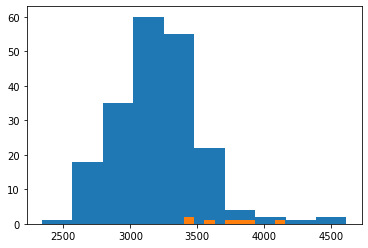

In [20]:
plt.subplot()
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].loss)
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='scint'].loss)

In [21]:
F,p = mannwhitneyu(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].loss, df_encoded_hcp[df_encoded_hcp.Group=='scint'].loss)
print(p)

0.00010345271803248969


#### Reconstruction Error

(array([2., 0., 1., 0., 1., 1., 1., 0., 0., 1.]),
 array([3383. , 3458.4, 3533.8, 3609.2, 3684.6, 3760. , 3835.4, 3910.8,
        3986.2, 4061.6, 4137. ]),
 <BarContainer object of 10 artists>)

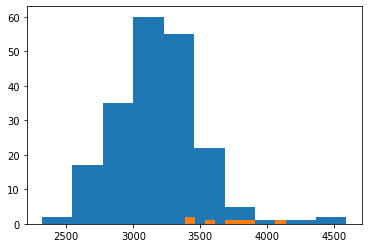

In [22]:
plt.subplot()
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].recon)
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='scint'].recon)

In [23]:
F,p = mannwhitneyu(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].recon, df_encoded_hcp[df_encoded_hcp.Group=='scint'].recon)
print(p)

9.225750926678489e-05


### Control subjects with loss in 95th percentile

In [24]:
percentile_95 = np.quantile(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].loss, 0.95)
uppest_loss = list(df_encoded_hcp[df_encoded_hcp.Group=='hcp'][df_encoded_hcp.loss>percentile_95]['sub'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [27]:
for sub in uppest_loss:
    enc = df_encoded_hcp[df_encoded_hcp['sub']==int(sub)].latent.values[0]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    out[out>0.8] = 1
    out[out<=0.8] = 0
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/distmap/analyses_gridsearch/4_2/{sub}.bck")

In [287]:
sub

704238

In [300]:
df_encoded_hcp[df_encoded_hcp['sub']==int(sub)].latent.values

array([array([-0.42013705,  1.1203433 , -0.15884572,  0.60257363, -0.28402683,
       -2.7880368 ,  0.83569455,  0.76004755,  1.3965697 ,  0.2605872 ,
       -0.16465773, -1.2730279 ,  1.195541  , -0.16416936,  0.9819592 ,
       -0.4220403 , -1.2272894 , -0.7997012 ,  0.13011843,  1.0490109 ,
       -1.3605357 ,  1.9852303 ,  0.00548672, -0.07781206, -0.6495438 ,
        0.64752173, -0.79837453, -2.3637593 , -0.31224748,  1.1651697 ,
       -0.9894311 , -0.9054861 ,  1.4454845 ,  1.9357519 , -0.57652944,
        0.5743346 ,  0.28482592, -0.6973809 ,  0.7171393 , -0.49741444,
        0.47907108,  1.2073052 , -1.4372306 , -0.81103015, -0.45052543,
       -0.29568586,  0.8347558 , -2.2329965 ,  1.5731368 , -0.45884562,
        0.42097884,  1.4239688 ,  0.29761818,  0.07908875,  2.0049353 ,
       -0.26128688,  1.4680082 , -0.9836953 ,  0.6801868 ,  1.6836429 ,
        1.347207  ,  0.6927469 , -1.4928259 ,  0.23232144,  1.9373187 ,
       -1.4621698 , -0.44835898,  1.350685  , -0.7148078 

In [283]:
df_encoded_hcp[['latent''sub']]

,latent,sub
0,"[1.4987683, -2.3709788, -0.38663277, -1.805903...",932554
1,"[1.2524024, 1.6419047, -0.8353577, -0.12615435...",387959
2,"[-0.11067161, 0.17486379, -0.8502037, 0.352294...",887373
3,"[-0.42013705, 1.1203433, -0.15884572, 0.602573...",704238
4,"[0.39948422, 2.767998, 0.6011206, -0.3999996, ...",169040
5,"[-2.2414525, -0.05261893, -0.3464897, -2.41340...",194746
6,"[-3.298634, -2.1918232, -0.00073624577, -0.599...",127832
7,"[-0.20477563, 1.008311, -0.500729, 0.8531343, ...",206727
8,"[-0.3006783, 0.7252304, 0.14118715, -0.7949637...",679770
9,"[0.40259424, 0.4275403, 0.40569162, 0.753658, ...",210112


### Application on on-handed subjects

In [107]:
X_oh = np.array(list(df_encoded_oh['latent']))
labels_oh = np.array(df_encoded_oh['Group'])

X_embedded_oh = TSNE(n_components=2, random_state=12, perplexity=12).fit_transform(X_oh)

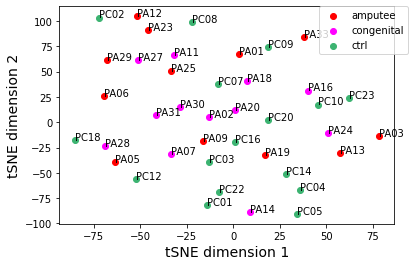

In [109]:
arr = X_embedded_oh
color_dict = {'ctrl':'mediumseagreen', 'amputee': 'red', 'congenital':'magenta'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_oh):
    ix = np.where(labels_oh == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

subjects_name_oh = list(df_encoded_oh['sub'])
for i, txt in enumerate(subjects_name_oh):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

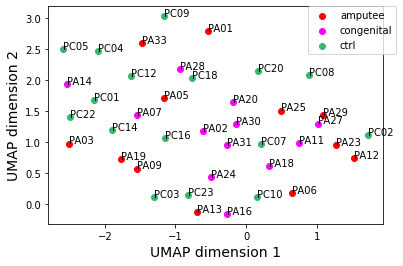

In [116]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_oh)

arr = embedding
color_dict = {'ctrl':'mediumseagreen', 'amputee': 'red', 'congenital':'magenta'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_oh):
    ix = np.where(labels_oh == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_oh):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [117]:
F,p = mannwhitneyu(df_encoded_oh[df_encoded_oh.Group=='ctrl'].loss, df_encoded_oh[df_encoded_oh.Group=='congenital'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_oh[df_encoded_oh.Group=='amputee'].loss, df_encoded_oh[df_encoded_oh.Group=='congenital'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_oh[df_encoded_oh.Group=='amputee'].loss, df_encoded_oh[df_encoded_oh.Group=='ctrl'].loss)
print(p)

0.170627464234072
0.38639097464336225
0.14278408993952219


(array([2., 1., 0., 4., 0., 0., 2., 1., 0., 2.]),
 array([1717., 1776., 1835., 1894., 1953., 2012., 2071., 2130., 2189.,
        2248., 2307.]),
 <BarContainer object of 10 artists>)

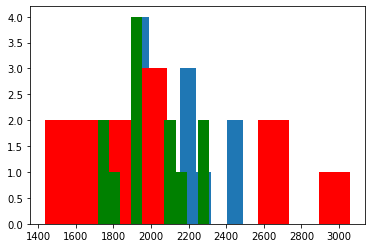

In [118]:
plt.subplot()
plt.hist(df_encoded_oh[df_encoded_oh.Group=='ctrl'].loss)
plt.hist(df_encoded_oh[df_encoded_oh.Group=='amputee'].loss, color='r')
plt.hist(df_encoded_oh[df_encoded_oh.Group=='congenital'].loss, color='g')

In [119]:
F,p = mannwhitneyu(df_encoded_oh[df_encoded_oh.Group=='ctrl'].loss, df_encoded_oh[df_encoded_oh.Group=='congenital'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_oh[df_encoded_oh.Group=='amputee'].loss, df_encoded_oh[df_encoded_oh.Group=='congenital'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_oh[df_encoded_oh.Group=='amputee'].loss, df_encoded_oh[df_encoded_oh.Group=='ctrl'].loss)
print(p)

0.170627464234072
0.38639097464336225
0.14278408993952219


(array([2., 1., 0., 4., 0., 0., 2., 1., 0., 2.]),
 array([1511. , 1569.3, 1627.6, 1685.9, 1744.2, 1802.5, 1860.8, 1919.1,
        1977.4, 2035.7, 2094. ]),
 <BarContainer object of 10 artists>)

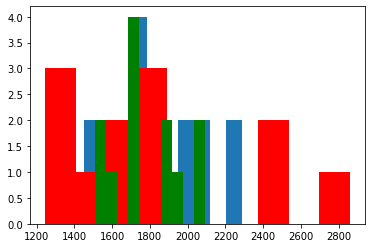

In [120]:
plt.subplot()
plt.hist(df_encoded_oh[df_encoded_oh.Group=='ctrl'].recon)
plt.hist(df_encoded_oh[df_encoded_oh.Group=='amputee'].recon, color='r')
plt.hist(df_encoded_oh[df_encoded_oh.Group=='congenital'].recon, color='g')

### On EUAIMS

In [28]:
df_encoded_aims = aims_data
X_aims = np.array(list(aims_data['latent']))
labels_aims = np.array(aims_data['Group'])

X_embedded_aims = TSNE(n_components=2, random_state=12, perplexity=30).fit_transform(X_aims)

In [234]:
(len(df_encoded_aims[df_encoded_aims.Group=='ctrl']) + len(df_encoded_aims[df_encoded_aims.Group=='id_ctrl']))**(1/2)

17.11724276862369

In [239]:
844**0.5

29.0516780926679

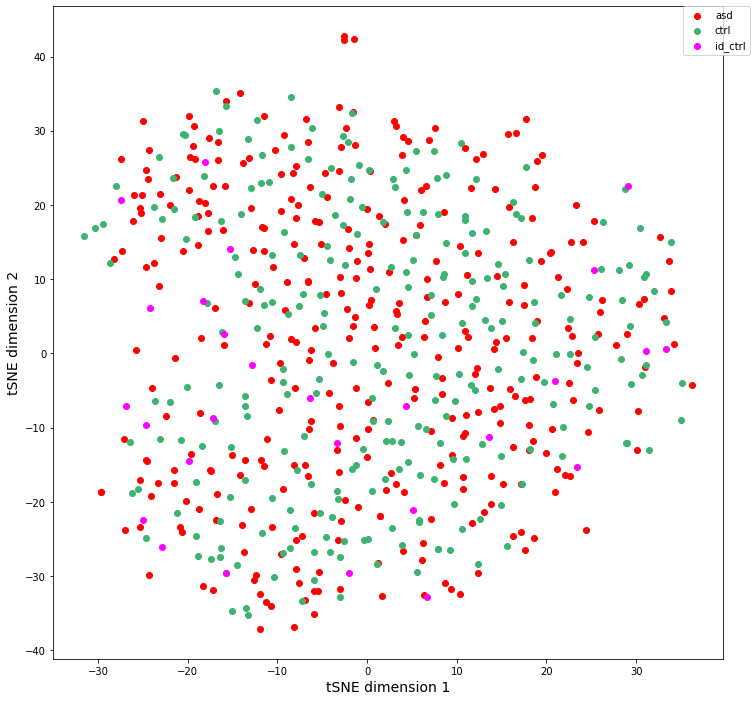

In [29]:
arr = X_embedded_aims
color_dict = {'ctrl':'mediumseagreen', 'asd': 'red', 'id_ctrl':'magenta'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(labels_aims):
    ix = np.where(labels_aims == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

subjects_name_aims = list(df_encoded_aims['sub'])
#for i, txt in enumerate(subjects_name_aims):
#    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

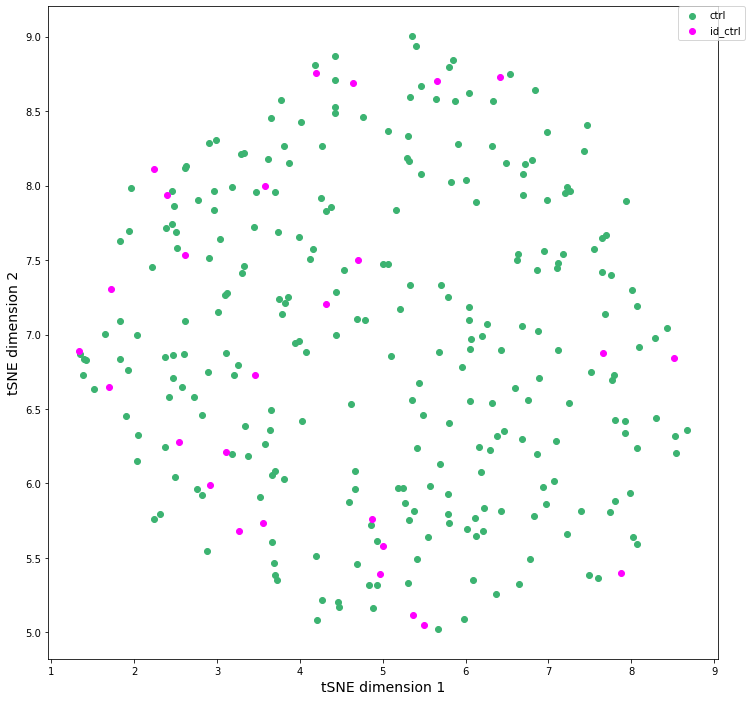

In [31]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_aims)

arr = embedding
color_dict = {'ctrl':'mediumseagreen', 'asd': 'red', 'id_ctrl':'magenta'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(labels_aims):
    if g != 'asd':
        ix = np.where(labels_aims == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        g_lab= f"{g}"
        ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
# for i, txt in enumerate(subjects_name_aims):
#     ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

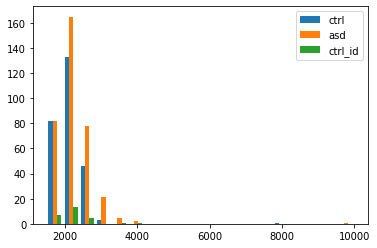

In [33]:
bins = np.linspace(1500, 10000, 20)

plt.hist([df_encoded_aims[df_encoded_aims.Group=='ctrl'].loss, df_encoded_aims[df_encoded_aims.Group=='asd'].loss, df_encoded_aims[df_encoded_aims.Group=='id_ctrl'].loss], bins, label=['ctrl', 'asd', 'ctrl_id'])
plt.legend(loc='upper right')
plt.show()

In [34]:
F,p = mannwhitneyu(list(df_encoded_aims[df_encoded_aims.Group=='ctrl'].loss), list(df_encoded_aims[df_encoded_aims.Group=='asd'].loss))
print(p)
F,p = mannwhitneyu(list(df_encoded_aims[df_encoded_aims.Group=='ctrl'].loss), list(df_encoded_aims[df_encoded_aims.Group=='id_ctrl'].loss))
print(p)

0.00015137006349626346
0.4039396894292667


In [35]:
ttest_ind(list(df_encoded_aims[df_encoded_aims.Group=='ctrl'].loss), list(df_encoded_aims[df_encoded_aims.Group=='asd'].loss))

Ttest_indResult(statistic=-2.9013694768374534, pvalue=0.0038475992624235943)

In [212]:
len(df_encoded_aims[df_encoded_aims.Group=='asd'])

354

In [259]:
results['scint'].keys()

dict_keys(['138231', '510225', '159946', '140319', '212419', '199251', '111009'])

In [450]:
losses['scint']

[3152, 3376, 3060, 2545, 3610, 3016, 3605]

In [216]:
from scipy import stats

In [452]:
print(np.std(losses['hcp']))
print(np.std(losses['scint']))

330.64370914928963
347.9944287614093


In [187]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
for k in range(200, 207):
    print(neigh.kneighbors(np.expand_dims(X[k], axis=0)))

(array([[ 0.        , 11.69054825, 12.00801633, 13.4761403 ]]), array([[200, 206, 210, 224]]))
(array([[ 0.        , 13.45366735, 13.96529384, 14.17247194]]), array([[201, 215, 208, 214]]))
(array([[ 0.        , 14.1431712 , 14.67249479, 14.83832237]]), array([[202, 218, 228, 247]]))
(array([[ 0.        , 13.09613229, 13.41196201, 13.99237086]]), array([[203, 221, 215, 217]]))
(array([[ 0.        , 14.99152268, 15.96027309, 16.04859976]]), array([[204,  28, 127, 215]]))
(array([[ 0.        , 13.33081389, 13.67092942, 13.76308412]]), array([[205, 210, 208, 226]]))
(array([[ 0.        , 11.69054825, 13.38221995, 13.43525141]]), array([[206, 200, 210, 224]]))


In [188]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
for k in range(200, 207):
    print(neigh.kneighbors(np.expand_dims(X[k], axis=0)))

(array([[ 0.        , 11.69054825, 12.00801633, 13.4761403 ]]), array([[200, 206, 210, 224]]))
(array([[ 0.        , 13.45366735, 13.96529384, 14.17247194]]), array([[201, 215, 208, 214]]))
(array([[ 0.        , 14.1431712 , 14.67249479, 14.83832237]]), array([[202, 218, 228, 247]]))
(array([[ 0.        , 13.09613229, 13.41196201, 13.99237086]]), array([[203, 221, 215, 217]]))
(array([[ 0.        , 14.99152268, 15.96027309, 16.04859976]]), array([[204,  28, 127, 215]]))
(array([[ 0.        , 13.33081389, 13.67092942, 13.76308412]]), array([[205, 210, 208, 226]]))
(array([[ 0.        , 11.69054825, 13.38221995, 13.43525141]]), array([[206, 200, 210, 224]]))


In [390]:
sub['hcp'][49]

168139

In [280]:
filenames_scint

array(['138231', '510225', '159946', '140319', '212419', '199251',
       '111009'], dtype='<U6')

### Study of reconstruction error as anomaly score

In [394]:
idx = np.where(np.array(losses['hcp'])>3000)

In [401]:
sub['hcp'][idx]

array([887373, 704238, 679770, 124422, 872158, 942658, 168038, 802844,
       116221, 100206, 172534, 329440, 180937, 965367, 351938, 185038,
       145632, 199958, 121416, 731140, 135730, 104012, 117122, 176239,
       123824, 275645, 189450, 167440, 891667, 139839, 120010, 510326,
       456346, 573249, 175035, 211720])

In [464]:
enc = encoded['hcp'][10]

In [417]:
enc.shape

(20,)

In [465]:
arr_out = []
values = []

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

# arr_out = np.array(arr_out)
# np.save(f"/volatile/arr_out.npy", arr_out)
# np.save('/volatile/arr_label.npy', np.array(values))

In [466]:
out[out>0.5] = 1
out[out<=0.5] = 0

In [467]:
aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/volatile/bucket_test.bck")